# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 01.10.2023

Мягкий дедлайн: 23:59MSK 15.10.2023

Жесткий дедлайн: 23:59MSK 20.10.2023

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

Итогова оценка считается как
$$
min(task_1, task_2)*0.8 + max(task_1, task_2)*0.2
$$

где task_1 и task_2 - оценки за первое и второе заданиее соответсвенно.
Также, за домашнее задание выставляется 0, если не сделано нулевое или третье задание.
### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2024-08-29 11:07:52--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [   <=>              ] 201.24M  35.1MB/s    in 6.1s    

2024-08-29 11:07:59 (32.8 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


Мы вывели кусок данных, чтобы понять, насколько они пригодны для работы без изменений. Здесь ясно, что сомнительно дальше с такими данными работать, потому что как минимум есть отрицательные значения, которые не отмасштабированы, кроме того еще сразу бросается в глаза совсем разная размерность, где-то видим реально большие числа, а где-то 0.075. Ясно, что будем скейлить.

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
len(np.unique(y))

89

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

Для выполнения данного задания (и всех последующих) предобработайте данные.

1. Зафиксируйте random_seed везде где только возможно. Вам предоставлена функция для этого, однако вы можете дополнить ее своими дополнениями
2. Обучите StandertScaler и предобработайте ваши данные. В следующих заданиях можете использовать другой scaler или вообще отказаться от него


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

NameError: name 'X_train' is not defined

In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    # Add smth here if you need...
    # На тренировочную и тестовую побили выше фиксированно

In [ ]:
set_random_seed(42)

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from scipy import stats

alphas_array = np.arange(0.01, 1, 0.1)

params = {"alpha": alphas_array}

# model = GridSearchCV(RidgeClassifier(), params, scoring = "accuracy", cv = 5, verbose=3)

# model.fit(X_train, y_train)


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

params = {"alpha": (0.001, 1.0)}

model_r = RandomizedSearchCV(RidgeClassifier(), params, scoring = "accuracy", cv = 5, verbose=3)

model_r.fit(X_train, y_train)


In [ ]:
# dir(model)

# print(model.get_params())

y_pred = model.predict(X_test)
y_pred_r = model_r.predict(X_test)


rmse_for_model = np.sqrt(mse(y_test, y_pred))
rmse_for_model_r = np.sqrt(mse(y_test, y_pred_r))


print(f'{rmse_for_model = }')
print(f'{rmse_for_model_r = }')


print(f'{accuracy_score(y_test, y_pred) = }')
print(f'{accuracy_score(y_test, y_pred_r) = }')

random_pred = 1 / len(np.unique(y_test))

print(f'В {accuracy_score(y_test, y_pred) / random_pred} раз лучше рандомного ответа (при условии равномерного распределения классов)')


# np.unique(y_test, return_counts=True) # классы у нас неравномерно распределены

In [ ]:
model.best_params_, model_r.best_params_


Лучшая константа для RMSE это среднее, посчитаем значение метрики при нем

In [ ]:
y_pred = np.full(y_test.shape, np.round(np.mean(y_train)))

best_rmse_metric = np.sqrt(mse(y_test, y_pred))


print(f'{best_rmse_metric = }, {accuracy_score(y_test, y_pred) = }')

In [3]:
# КОД ДЛЯ ВЫЛЕТОВ


import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
device = "cuda" if torch.cuda.is_available() else "cpu"
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython import display
import matplotlib.pyplot as plt
import time

import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import accuracy_score
from scipy import stats

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from matplotlib.pyplot import figure

from IPython.display import clear_output


!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
df = pd.read_csv('data.txt.zip', header=None)


X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values


train_size = 463715

X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

--2024-09-17 15:50:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [ <=>                ] 201.24M  12.6MB/s    in 24s     

2024-09-17 15:50:34 (8.38 MB/s) - ‘data.txt.zip’ saved [211011981]



## Задание 1. (максимум 10 баллов)

Закрепите свои знания о том, как pytorch работает с обратным распространением ошибки, проделав следующие шаги:

1. Создайте модель линейной регрессии, которая будет состоять только из одного Linear слоя.
2. Напишите цикл обучения вашей линейной регрессии. В нем реализуйте подсчет функции потерь, сделайте шаг градиентного спуска. Запрещено использовать готовые оптимизаторы и loss-функции из библиотеки pytorch. Для подсчета градиента воспользуйтесь методом backward.
3. Запустите обучение на 10 эпохах, после каждой проверяйте значение целевой метрики на тестовой выборке.
4. Выведите на экран графики метрики и значения функции потерь на тестовой и обучающей выборке.

В данном задании нет цели побить какой-то порог по метрике. Ваша задача - убедиться в том, что ваш рукописный цикл обучения работает. Для ускорения вычислений и обучения модели можете брать только срез данных, а не весь датасет.

In [ ]:
torch.set_printoptions(sci_mode=False)

# РАЗБИРАЕМСЯ С ДАННЫМИ

torch_x_train = torch.tensor(X_train, dtype=torch.float32)
torch_y_train = torch.tensor(y_train, dtype=torch.int16)

torch_x_test = torch.tensor(X_test, dtype=torch.float32)
torch_y_test = torch.tensor(y_test, dtype=torch.int16)


class KostylDataloader():

  def __init__(self, x, y, batch_size):
    self.x = x
    self.y = y
    self.batch_size = batch_size
    self.current_batch = 0
    self.iter_is_over = False
    self.total_batches = len(self.x) // self.batch_size


  def next_batch_target(self):
    if self.iter_is_over:
       raise Exception('Пытаетесь вытащить батч из уже перебранного датасета')

    start = self.batch_size * self.current_batch
    end = start + self.batch_size

    if end == len(self.x):
      self.iter_is_over = True

    if end > len(self.x):
      self.iter_is_over = True
      end = len(self.x)

    self.current_batch += 1

    return self.x[start:end], self.y[start:end]


  def reset(self):
    self.current_batch = 0
    self.iter_is_over = False
    indices = torch.randperm(self.x.size()[0])
    self.x=self.x[indices]
    self.y=self.y[indices]

  def show_progress(self):
    if self.current_batch % 5000 == 0:
      print(f'Processing batch {self.current_batch} out of {self.total_batches}')
      return True
    return False



# len(torch_y_train)
# 463 715

In [ ]:
# СОЗДАЁМ МОДЕЛЬ С ОДНИМ ЛИНЕЙНЫМ СЛОЕМ

model = nn.Sequential(nn.Linear(90, 1), nn.ReLU())

# model.add_module()
# есть ощущение, что нужно делать 89 выходных слоёв, т.к. у нас классификация,
# но пока сделаем регрессию + ф-ия потерь соответствующая будет

lr = 0.005
batch_size = 24

kostyl_dataloader = KostylDataloader(torch_x_train, torch_y_train, batch_size)

# torch.autograd.set_detect_anomaly(True)


epochs = 10

learning_log = {}


learning_log[0] = [float(torch.mean((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)),
                          float(torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))),
                          float(torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)),
                          float(torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2))))]


for epoch in range(epochs):
  print('=========================================')
  print(f'Эпоха {epoch+1} из {epochs}')

  print(f'Сейчас RMSE на тесте: {torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)))}\n')

  kostyl_dataloader.reset()
  i = 0

  while not kostyl_dataloader.iter_is_over:
    i+=1
    batch, target = kostyl_dataloader.next_batch_target()

    loss = torch.mean((model(batch) - target) ** 2)
    loss.backward()

    if kostyl_dataloader.show_progress() and i % 5000 == 0:
      # print(f'{model[0].weight.grad = }')
      print(f'ЛОСС на шаге {i} (эпоха {epoch+1}): {loss}\n')
      learning_log[str(epoch+1)+'-'+str(i)] = [float(torch.mean((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)),
                               float(torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))),
                               float(torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)),
                               float(torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2))))]

    step_weight = model[0].weight.grad.data * lr
    step_bias = model[0].bias.grad.data * lr

    model[0].weight.data -= step_weight
    model[0].bias.data -= step_bias
    model[0].weight.grad.zero_()
    model[0].bias.grad.zero_()

    # if kostyl_dataloader.iter_is_over:
    #   learning_log[epoch+1] = [float(torch.mean((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)),
    #                            float(torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))),
    #                            float(torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)),
    #                            float(torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2))))]
      # print(f'Loss на трейне: {loss}')
      # print(f'RMSE на трейне: {torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))}')
      # print(f'Loss на тесте: {torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)}')
      # print(f'RMSE на тесте: {torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)))}')


print(f'\n\nТеперь RMSE на тесте: {torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)))}\n')


Эпоха 1 из 10
Сейчас RMSE на тесте: 1997.5308837890625



KeyboardInterrupt: 

In [ ]:
# СОЗДАЁМ МОДЕЛЬ С ОДНИМ ЛИНЕЙНЫМ СЛОЕМ

model = nn.Sequential(nn.Linear(90, 1), nn.ReLU())

# model.add_module()
# есть ощущение, что нужно делать 89 выходных слоёв, т.к. у нас классификация,
# но пока сделаем регрессию + ф-ия потерь соответствующая будет

lr = 0.0001
batch_size = 24

kostyl_dataloader = KostylDataloader(torch_x_train, torch_y_train, batch_size)

# torch.autograd.set_detect_anomaly(True)


epochs = 10

learning_log_2 = {}


learning_log_2[0] = [float(torch.mean((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)),
                          float(torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))),
                          float(torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)),
                          float(torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2))))]


for epoch in range(epochs):
  print('=========================================')
  print(f'Эпоха {epoch+1} из {epochs}')

  print(f'Сейчас RMSE на тесте: {torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)))}\n')

  kostyl_dataloader.reset()
  i = 0

  while not kostyl_dataloader.iter_is_over:
    i+=1
    batch, target = kostyl_dataloader.next_batch_target()

    loss = torch.mean((model(batch) - target) ** 2)
    loss.backward()

    if kostyl_dataloader.show_progress() and i % 5000 == 0:
      # print(f'{model[0].weight.grad = }')
      print(f'ЛОСС на шаге {i} (эпоха {epoch+1}): {loss}\n')
      learning_log_2[str(epoch+1)+'-'+str(i)] = [float(torch.mean((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)),
                               float(torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))),
                               float(torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)),
                               float(torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2))))]

    step_weight = model[0].weight.grad.data * lr
    step_bias = model[0].bias.grad.data * lr

    model[0].weight.data -= step_weight
    model[0].bias.data -= step_bias
    model[0].weight.grad.zero_()
    model[0].bias.grad.zero_()

    # if kostyl_dataloader.iter_is_over:
    #   learning_log[epoch+1] = [float(torch.mean((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)),
    #                            float(torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))),
    #                            float(torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)),
    #                            float(torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2))))]
      # print(f'Loss на трейне: {loss}')
      # print(f'RMSE на трейне: {torch.mean(torch.sqrt(((model(torch_x_train[:1000]) - torch_y_train[:1000]) ** 2)))}')
      # print(f'Loss на тесте: {torch.mean((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)}')
      # print(f'RMSE на тесте: {torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)))}')


print(f'\n\nТеперь RMSE на тесте: {torch.mean(torch.sqrt(((model(torch_x_test[:1000]) - torch_y_test[:1000]) ** 2)))}\n')


In [ ]:
def train(model, optimizer, criterion,
          train_loader, test_loader,
          device, num_epochs=15, svechi=2, tittle=0.1, scheduler=None):

    model.to(device)
    model.train()
    # print(f'{model.training = }')

    # MEASURING INITIAL METRICS
    # prev_rmse_train = get_rmse(model, torch_x_train, torch_y_train)
    # prev_rmse_test = get_rmse(model, torch_x_test, torch_y_test)
    # beginning = f'Initial metrics TRAIN: {prev_rmse_train:.2f} TEST: {prev_rmse_test:.2f}'
    # print(beginning)

    start_time = time.time()
    ne_stoit_svech = 0
    # best_rmse_test = prev_rmse_test
    avg_losses = []
    rmse_trains = []
    rmse_tests = []

    for epoch in range(num_epochs):
      print(f'\nEpoch {epoch+1}/{num_epochs}')

      accumulated_loss = 0.0

      for samples, targets in tqdm(train_loader):
        samples.to(device)
        targets.to(device)
        predictions = model(samples)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accumulated_loss += loss.item()

      if scheduler:
        scheduler.step()

      # MEASURE CURRENT METRICS
      avg_train_loss = accumulated_loss / len(train_loader)
      avg_losses.append(avg_train_loss)
      # rmse_train = get_rmse(model, torch_x_train, torch_y_train)
      # rmse_trains.append(rmse_train)
      # rmse_test = get_rmse(model, torch_x_test, torch_y_test)
      # rmse_tests.append(rmse_test)


      # DRAWING PROGRESS PLOT
      clear_output()
      # print(beginning)
      print(f'\nEPOCH NUMBER {epoch+1}\n')

      figure(figsize=(6,4))


      # plt.subplot(1, 2, 1)
      plt.xlim(0, num_epochs-1)
      plt.ylim(0.6, 1)
      plt.plot(avg_losses)
      if epoch == 0:
        plt.plot(epoch, avg_train_loss, marker='o', markersize=5)
      plt.title('Avg train loss batchwise')

      # plt.subplot(1, 2, 2)
      # plt.xlim(0, num_epochs-1)
      # plt.ylim(10, 11)
      # plt.plot(rmse_trains, color='blue')
      # plt.plot(rmse_tests, color='orange')
      # if epoch == 0:
      #   plt.plot(epoch, rmse_train, marker='o', markersize=5, color='blue')
      #   plt.plot(epoch, rmse_train, marker='o', markersize=5, color='orange')
      # plt.title('Train and test losses')
      plt.tight_layout()
      plt.show()


      # print(f'\nTRAIN rmse: {rmse_train:.3f}, {((prev_rmse_train - rmse_train) / prev_rmse_train * 100):.1f}% better')
      # print(f'TEST rmse: {rmse_test:.3f}, {((prev_rmse_test - rmse_test) / prev_rmse_test * 100):.1f}% better')
      print(f'{avg_train_loss = :.5f}')
      print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')

      # UPDATING BEST TEST MSE
      # if rmse_test < best_rmse_test: best_rmse_test = rmse_test

      # CHECK IF TRAINING STILL GOING ANYWHERE
      # progress_test = (prev_rmse_test - rmse_test) / prev_rmse_test * 100
      # progress_train = (prev_rmse_train - rmse_train) / prev_rmse_train * 100
      # if progress_test < tittle and progress_train < tittle:
      #   ne_stoit_svech += 1
      # else:
      #   ne_stoit_svech = 0
      # if ne_stoit_svech > svechi:
      #   print(f'\n\nNo progress for {svechi} epochs, training stopped at epoch {epoch+1}')
      #   break

      # prev_rmse_train, prev_rmse_test = rmse_train, rmse_test


    end_time = time.time()
    training_time = round((end_time - start_time)/60, 1)

    print(f'\nTraining time:\t\t{training_time}')
    print(f'Num of epochs:\t\t{epoch + 1}')
    # print(f'Best RMSE (test):\t{best_rmse_test:.3f}')



def test(model, criterion, test_loader, device):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    with torch.no_grad():
      for inputs, _ in test_loader:
          inputs = inputs.to(device)
          predicts = model(inputs)

    return predicts



def get_rmse(model, x, y):


    with torch.no_grad():
      model.eval()
      predictions = model(x)
      model.train()
      predictions = scaler_y.inverse_transform(predictions.detach().numpy())
      # predictions = predictions.detach().numpy()

      rmse = np.sqrt(mean_squared_error(y.detach().numpy(),
                                              predictions))

    return rmse


In [ ]:
import seaborn as sns

ll = pd.DataFrame(learning_log_2).T
ll.columns = ['train loss', 'train rmse', 'test loss', 'test rmse']

ll['i'] = range(len(ll))

ll = ll.iloc[1:, :]

ll_loss = ll[['i', 'train loss', 'test loss']]
ll_rmse = ll[['i', 'train rmse', 'test rmse']]

sns.lineplot(x=ll_loss['i'], y=ll_loss['train loss'])
sns.lineplot(x=ll_loss['i'], y=ll_loss['test loss'])
plt.show()
sns.lineplot(x=ll_rmse['i'], y=ll_rmse['train rmse'])
sns.lineplot(x=ll_rmse['i'], y=ll_rmse['test rmse'])

# ll

In [ ]:
# # class Model(nn.Module):
# #     def __init__(self):
# #       super(Model, self).__init__()
# #       self.fc1 = nn.Linear(90, 89)
# #       self.relu = nn.ReLU()

# #       # self.dropout_input = nn.Dropout(0.2)
# #       # self.dropout = nn.Dropout(dropout_prob)

# #     def forward(self, x):
# #       x = self.fc1(x)
# #       x = self.relu(x)

# #       # x = self.dropout_input(x)
# #       # x = self.dropout(x)


# #       return x



# model = nn.Sequential(
#     nn.Linear(90, 89)
#     nn.ReLU())

# loss =

# # y_pred = model(batch['sample'])

# # y_pred, batch['target']


## Задание 2. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из предыдущего задания.



Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться сигнатурами функций, которые приведены ниже. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [4]:
# ДАННЫЕ

class MySet(torch.utils.data.Dataset):

  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return (self.x[idx, :],
            self.y[idx])

# Тестовые данные тут, потому что нечего в них менять и настраивать
torch_y_test = torch.tensor(y_test, dtype=torch.float32)

In [20]:
# ДАННЫЕ


# НОРМАЛИЗАЦИЯ ПРИЗНАКОВ
scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)
torch_x_train = torch.tensor(X_train, dtype=torch.float32)
torch_x_test = torch.tensor(X_test, dtype=torch.float32)


# НОРМАЛИЗАЦИЯ ТАРГЕТОВ
scaler_y = StandardScaler()
second_scaler = MinMaxScaler()
y_train_raw = y_train
y_train_shifted = y_train - 1922
y_train_norm = scaler_y.fit_transform(y_train_shifted.reshape(-1,1))
torch_y_train = torch.tensor(y_train, dtype=torch.float32)
torch_y_train_norm = torch.tensor(y_train_norm, dtype=torch.float32)

# БАТЧ САЙЗ
batch_size = 32

# РАЗМЕР ВЫБОРКИ НА ТРЕНИРОВКУ
light_size = 10000

light_train_x = torch_x_train[:light_size, :]
light_train_y = torch_y_train_norm[:light_size]
light_train_y_raw = torch_y_train[:light_size]


# ШАФФЛ
shuffle = False

# ДАТАЛОАДЕР

train_light_set = MySet(light_train_x, light_train_y)
train_light_loader = torch.utils.data.DataLoader(train_light_set, batch_size=batch_size, shuffle=shuffle)


# FULL DATALOADER
train_set = MySet(torch_x_train, torch_y_train_norm)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)

# TEST DATALOADER
test_set = MySet(torch_x_test, torch_y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=len(torch_y_test))



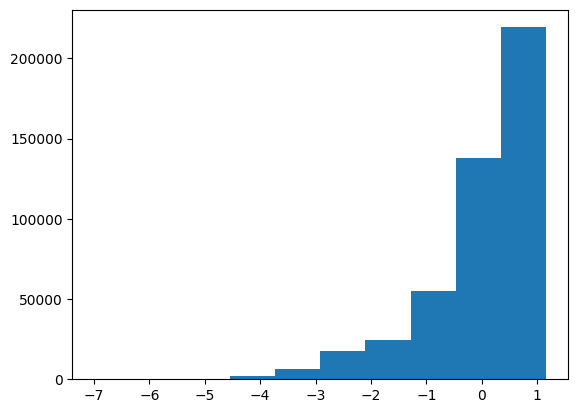

In [82]:
plt.hist(y_train_norm)
plt.show()

In [6]:
def train(model, optimizer, criterion, train_loader,
          device, num_epochs=15, scheduler=None):

    model.to(device)
    model.train()

    avg_losses = []

    for epoch in range(num_epochs):
      print(f'\nEpoch {epoch+1}/{num_epochs}')

      accumulated_loss = 0.0

      for samples, targets in tqdm(train_loader):
        samples = samples.to(device)
        targets = targets.to(device)
        predictions = model(samples)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accumulated_loss += loss.item()
      if scheduler:
        scheduler.step()

      avg_train_loss = accumulated_loss / len(train_loader)
      avg_losses.append(avg_train_loss)

      # DRAWING PROGRESS PLOT
      clear_output()
      print(f'\nEPOCH NUMBER {epoch+1}\n')
      figure(figsize=(6,4))
      plt.xlim(0, num_epochs-1)
      plt.ylim(0.6, 1)
      plt.plot(avg_losses)
      plt.title('Avg train loss batchwise')
      plt.show()

      print(f'{avg_train_loss = :.5f}')
      print(f'LR: {optimizer.param_groups[0]["lr"]:.6f}')


In [40]:
def train(model, optimizer, criterion,
          train_loader, device, num_epochs=15, svechi=2, tittle=0.1, scheduler=None):

    model.to(device)
    model.train()

    # MEASURING INITIAL METRICS
    prev_rmse_train = get_rmse(model, torch_x_train, torch_y_train)
    prev_rmse_test = get_rmse(model, torch_x_test, torch_y_test)
    beginning = f'Initial metrics TRAIN: {prev_rmse_train:.2f} TEST: {prev_rmse_test:.2f}'
    print(beginning)

    start_time = time.time()
    ne_stoit_svech = 0
    best_rmse_test = prev_rmse_test
    avg_losses = []
    rmse_trains = []
    rmse_tests = []

    stop_learning = False

    loss = torch.zeros(0, requires_grad=True)
    print(f'{loss.requires_grad = }')

    for epoch in range(num_epochs):
      print(f'\nEpoch {epoch+1}/{num_epochs}')

      accumulated_loss = 0.0

      steps = len(train_loader)
      reporting_times = 20
      reporting_steps = []

      for i in range(reporting_times + 1):
        step_num = int((steps / reporting_times) * i)
        reporting_steps.append(step_num)

      reporting_steps[-1] -= 1


      no_best_updates = 0

      step = 0
      for samples, targets in tqdm(train_loader):
        step += 1
        torch.set_grad_enabled(True)  # Context-manager
        samples = samples.to(device)
        targets = targets.to(device)
        predictions = model(samples)
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        accumulated_loss += loss.item()

        if step in reporting_steps:
          avg_train_loss = accumulated_loss / step
          avg_losses.append(avg_train_loss)
          rmse_train = get_rmse(model, light_train_x, light_train_y_raw)
          rmse_trains.append(rmse_train)
          rmse_test = get_rmse(model, torch_x_test, torch_y_test)
          rmse_tests.append(rmse_test)

          if rmse_test < best_rmse_test:
            best_rmse_test = rmse_test
            no_best_updates = 0
            if best_rmse_test < 8.75:
              stop_learning = True
              break
          else:
            no_best_updates += 1



          line_1 = f'\nTRAIN rmse: {rmse_train:.3f}, {((prev_rmse_train - rmse_train) / prev_rmse_train * 100):.1f}% better'
          line_2 = f'TEST rmse: {rmse_test:.3f}, {((prev_rmse_test - rmse_test) / prev_rmse_test * 100):.1f}% better'
          line_3 = f'{avg_train_loss = :.5f}'
          line_4 = f'{best_rmse_test = }\nlast update of best_rmse_test: {no_best_updates}'

          draw_progress(avg_losses, rmse_trains, rmse_tests, beginning, epoch, (epoch+1)*reporting_times, line_1, line_2, line_3, line_4)

      if stop_learning:
        break

      if scheduler:
        scheduler.step()


      # UPDATING BEST TEST MSE
      if rmse_test < best_rmse_test: best_rmse_test = rmse_test

      prev_rmse_train, prev_rmse_test = rmse_train, rmse_test


    end_time = time.time()
    training_time = round((end_time - start_time)/60, 1)

    print(f'\nTraining time:\t\t{training_time}')
    print(f'Num of epochs:\t\t{epoch + 1}')
    print(f'Best RMSE (test):\t{best_rmse_test:.3f}')



def test(model, criterion, test_loader, device):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    model.eval()
    with torch.no_grad():
      for inputs, _ in test_loader:
          inputs = inputs.to(device)
          predicts = model(inputs)

    return predicts


def draw_progress(avg_losses, rmse_trains, rmse_tests, beginning, epoch, num_epochs, l1, l2, l3, l4):
      # DRAWING PROGRESS PLOT
      clear_output()
      print(beginning)
      print(f'\EPOCH NUMBER {epoch+1}\n')

      figure(figsize=(6,4))


      plt.subplot(1, 2, 1)
      plt.xlim(0, num_epochs-1)
      plt.ylim(0.3, 1)
      plt.plot(avg_losses)
      plt.title('Avg train loss batchwise')

      plt.subplot(1, 2, 2)
      plt.xlim(0, num_epochs-1)
      plt.ylim(8, 11)
      plt.plot(rmse_trains, color='blue')
      plt.plot(rmse_tests, color='orange')
      plt.title('Train and test losses')
      plt.tight_layout()
      plt.show()

      for l in [l1, l2, l3, l4]:
        print(l)


def get_rmse(model, x, y):


    with torch.no_grad():
      model.eval()
      predictions = model(x.to('cuda'))
      model.train()
      predictions = scaler_y.inverse_transform(predictions.cpu().detach().numpy()) + 1922
      # predictions = predictions.detach().numpy()

      rmse = np.sqrt(mean_squared_error(y.detach().numpy(),
                                              predictions))


    return rmse


Initial metrics TRAIN: 11.04 TEST: 10.94
\EPOCH NUMBER 22



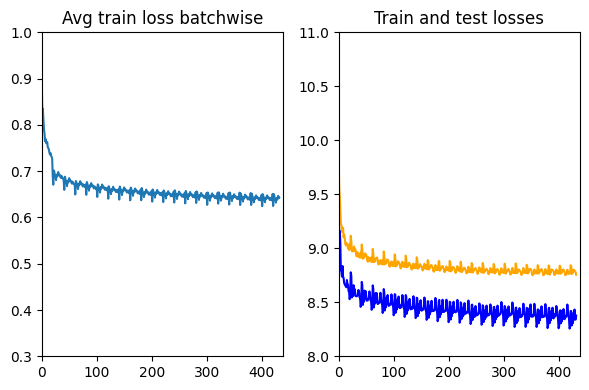


TRAIN rmse: 8.377, -0.4% better
TEST rmse: 8.755, 0.1% better
avg_train_loss = 0.64295
best_rmse_test = 8.750171
last update of best_rmse_test: 13

Training time:		16.9
Num of epochs:		22
Best RMSE (test):	8.748
light_size = 10000
shuffle = False
batch_size = 32
scheduler = None


In [41]:
import warnings
warnings.filterwarnings("ignore")


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = nn.Sequential(
    nn.Linear(90, 64),
    # nn.BatchNorm1d(64),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(64, 64),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(64, 40),
    nn.GELU(),
    nn.Linear(40, 40),
    nn.GELU(),
    nn.Dropout(0.3),
    nn.Linear(40, 1)
)

criterion = nn.MSELoss()
n_epoch = 50
lr = 0.0002

weight_decay = 0

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

scheduler = None
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train(model, optimizer, criterion, train_loader, device, n_epoch, scheduler)

print(f'{light_size = }')
print(f'{shuffle = }')
print(f'{batch_size = }')
print(f'{scheduler = }')


# 128 -- 40 -- 8.752789

In [44]:
model.eval()
y_pred = model(torch_x_test.to('cuda')).cpu().detach().numpy().squeeze()
y_pred = scaler_y.inverse_transform(y_pred.reshape(-1, 1)) + 1922
np.sqrt(mean_squared_error(y_test, y_pred))
# y_pred



8.747788903732566

## Задание 3. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

Эксперимент 1 (однослойная):
- fc1(90 -> 1), relu
- batch_size = 16
- lr = 0.01
- epoch_num = 10
- **RMSE train = 9.7467**
- **RMSE test = 9.7074**
- **Время обучения: 7 минут**


Эксперимент 2 (однослойная + дропаут):
- fc1(90 -> 1), relu
- batch_size = 16
- lr = 0.01
- epoch_num = 10
- dropout_prob = 0.4
- **RMSE train = 10.2091**
- **RMSE test = 10.1742**
- **Время обучения: 7 минут**


Эксперимент 3 (однослойная + динамически меняющийся lr):
- fc1(90 -> 1), relu
- batch_size = 16
- lr = 0.08 (с середины начинает делиться на 2.5 на каждой эпохе)
- epoch_num = 12
- **RMSE train = 9.6652**
- **RMSE test = 9.6108**
- **Время обучения: 6 минут**

Эксперимент 4 (двуслойная + динамически меняющийся lr + дропаут):
- fc1(90 -> 10), relu, fc2(10 -> 1), relu
- batch_size = 16
- lr = [0.08, 0.07, 0.05, 0.03, 0.01, 0.005, 0.0025, 0.00125, 0.0005, 0.0002, 0.0001, 0.00005, 0.00002, 0.00001, 0.00005]
- epoch_num = 15
- **RMSE train = 9.5642**
- **RMSE test = 9.5416**
- **Время обучения: 7 минут**

*Отсюда начал учить на обрезанной выборке и со scheduler*

Эксперимент 5 (разобрался со встроенным динамическим lr -- scheduler):
- 'layers': ['fc1', 'relu'],
- 'num_of_epochs': 79,
- 'training_time': 1.6,
- 'lr': 0.00036412416754732086,
- 'weight_decay': 0,
- 'best_test_rmse': 9.790949


Эксперимент 6 (двухслойная):
- 'layers': ['fc1', 'relu', 'fc2'],
- 'num_of_epochs': 100,
- 'training_time': 2.4,
- 'lr': 3.984209833138131e-05,
- 'weight_decay': 0,
- 'best_test_rmse': 9.905472


Эксперимент 7 (двухслойная с дропаутом):




Эксперимент 8 (однослойная с дропаутом 0.4):
- 'layers': ['fc1', 'relu', 'dropout'],
- 'num_of_epochs': 100,
- 'training_time': 2.0,
- 'lr': 3.984209833138131e-05,
- 'weight_decay': 0,
- 'best_test_rmse': 9.7885275,
- 'dropout_prob': 0.4


Эксперимент 9 (однослойная с утечкой весов):
- 'layers': ['fc1', 'relu'],
- 'num_of_epochs': 100,
- 'training_time': 2.0,
- 'lr': 3.984209833138131e-05,
- 'weight_decay': 0.001,
- 'best_test_rmse': 9.79376


In [ ]:
# на всей выборке
 {'layers': ['fc1', 'relu', 'dropout'],
 'num_of_epochs': 5,
 'training_time': 4.9,
 'lr': 5.904900000000002e-05,
 'weight_decay': 0,
 'best_test_rmse': 10.671181,
 'dropout_prob': 0.1}

{'layers': ['fc1', 'relu', 'dropout'],
 'num_of_epochs': 5,
 'training_time': 4.9,
 'lr': 5.904900000000002e-05,
 'weight_decay': 0.1,
 'best_test_rmse': 10.915395,
 'dropout_prob': 0.4}

{'layers': ['fc1', 'relu', 'dropout'],
 'num_of_epochs': 5,
 'training_time': 4.5,
 'lr': 5.904900000000002e-05,
 'weight_decay': 0.1,
 'best_test_rmse': 10.793044,
 'dropout_prob': 0}

{'layers': ['fc1', 'relu', 'dropout'],
 'num_of_epochs': 5,
 'training_time': 4.4,
 'lr': 0.00059049,
 'weight_decay': 0,
 'best_test_rmse': 9.839205,
 'dropout_prob': 0}

 {'layers': ['fc1', 'relu', 'dropout'],
 'num_of_epochs': 5,
 'training_time': 4.7,
 'lr': 0.00059049,
 'weight_decay': 0,
 'best_test_rmse': 10.613683,
 'dropout_prob': 0.1}